In [ ]:
#Reference:
# Rizvi, Mohd Sanad Zaki. "A Comprehensive Guide To Build Your Own Language Model In Python!". Medium, 2019, https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d.

import time
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Embedding, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
!git clone https://github.com/TTTTaiga/466_project.git
%cd 466_project/data
!ls
#filepath = "/content/The Republic by Plato.txt"
filepath = 'EBook_of_The_Republic.txt'

original_text = open(filepath, "r").read()
# since it takes too long to run the whole article, we choose part of it to train

data_text = original_text[: 30000]


print(type(data_text))
print(len(original_text))                                   
print(len(data_text))


Cloning into '466_project'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 29 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.
/content/466_project/data/466_project/data
EBook_of_The_Republic.txt  vaccination_tweets.csv
<class 'str'>
1214387
30000


In [ ]:
import re

def text_cleaner(text):
    # lower case text
    newString = text.lower()
    newString = re.sub(r"'s\b","",newString)
    # remove punctuations
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    long_words=[]
    # remove short word
    for i in newString.split():
        if len(i)>=3:                  
            long_words.append(i)
    return (" ".join(long_words)).strip()

# preprocess the text
data_new = text_cleaner(data_text)

print(data_new[0:500])

the project gutenberg ebook the republic plato this ebook for the use anyone anywhere cost and with almost restrictions whatsoever you may copy give away use under the terms the project gutenberg license included with this ebook online www gutenberg org title the republic author plato translator jowett posting date august ebook release date october last updated june language english start this project gutenberg ebook the republic produced sue asscher the republic plato translated benjamin jowett


In [ ]:
def create_seq(text):
    length = 30
    sequences = list()
    for i in range(length, len(text)):
        # select sequence of tokens
        seq = text[i-length:i+1]
        # store
        sequences.append(seq)
    print('Total Sequences: %d' % len(sequences))
    return sequences

# create sequences   
sequences = create_seq(data_new)

print(sequences[0:10])

Total Sequences: 25381
['the project gutenberg ebook the', 'he project gutenberg ebook the ', 'e project gutenberg ebook the r', ' project gutenberg ebook the re', 'project gutenberg ebook the rep', 'roject gutenberg ebook the repu', 'oject gutenberg ebook the repub', 'ject gutenberg ebook the republ', 'ect gutenberg ebook the republi', 'ct gutenberg ebook the republic']


In [ ]:
# create a character mapping index
chars = sorted(list(set(data_new)))
mapping = dict((c, i) for i, c in enumerate(chars))
print(mapping)

def encode_seq(seq):
    sequences = list()
    for line in seq:
      # integer encode line
      encoded_seq = [mapping[char] for char in line]

      # store
      sequences.append(encoded_seq)
    return sequences

# encode the sequences
sequences = encode_seq(sequences)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [ ]:
from sklearn.model_selection import train_test_split

# vocabulary size
vocab = len(mapping)
sequences = np.array(sequences)

# create X and y
X, y = sequences[:,:-1], sequences[:,-1]

# one hot encode y
y = to_categorical(y, num_classes=vocab)
# create train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print('Train shape:', X_tr.shape, 'Val shape:', X_val.shape)


Train shape: (22842, 30) Val shape: (2539, 30)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 20)            540       
_________________________________________________________________
gru_2 (GRU)                  (None, 150)               77400     
_________________________________________________________________
dense_2 (Dense)              (None, 27)                4077      
Total params: 82,017
Trainable params: 82,017
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
714/714 - 52s - loss: 2.4570 - acc: 0.2844 - val_loss: 2.2131 - val_acc: 0.3316
Epoch 2/50
714/714 - 49s - loss: 2.1435 - acc: 0.3585 - val_loss: 2.0955 - val_acc: 0.3647
Epoch 3/50
714/714 - 49s - loss: 2.0325 - acc: 0.3961 - val_loss: 1.9935 - val_acc: 0.4049
Epoch 4/50
714/714 - 49s - loss: 1.9254 - acc: 0.4309 - val_loss: 1.9052 - val_acc: 0.4403
Epoch 5/50


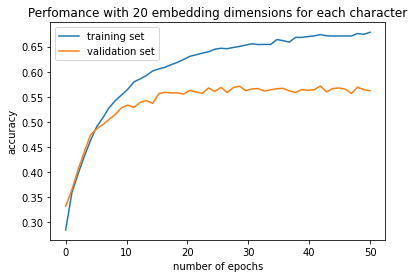

In [ ]:
# define model

num_embedding_dimension = 20
model = Sequential()
model.add(Embedding(vocab, num_embedding_dimension, input_length=30, trainable=True))
#model.add(SimpleRNN(150, recurrent_dropout=0.1, dropout=0.1))
model.add(GRU(150, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(vocab, activation='softmax'))
print(model.summary())

# get model plot
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# compile the model
hist = model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
# fit the model
start_time = time.time()
num_epochs = 50
hist = model.fit(X_tr, y_tr, epochs = num_epochs, verbose=2, validation_data=(X_val, y_val))

end_time = time.time()
print("Training takes", end_time - start_time)

# get graph
import matplotlib.pyplot as plt

train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
x = np.linspace(0,num_epochs, num_epochs)

plt.plot(x, train_acc, label = 'training set')
plt.plot(x, val_acc, label = 'validation set')

plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.title('Perfomance with %d embedding dimensions for each character' %(num_embedding_dimension))
plt.legend()
plt.show() 

In [ ]:
# generate a sequence of characters with a language model
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
	in_text = seed_text
	# generate a fixed number of characters
	for _ in range(n_chars):
		# encode the characters as integers
		encoded = [mapping[char] for char in in_text]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict character
		yhat = model.predict_classes(encoded, verbose=0)
		# reverse map integer to character
		out_char = ''
		for char, index in mapping.items():
			if index == yhat:
				out_char = char
				break
		# append to input
		in_text += char
	return in_text


In [ ]:
inp = 'it talks about'
print(generate_seq(model, mapping, 30, inp, len(inp) + 1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


it talks about the project gu
